# Convolutions

Last time, we learned about how to represent images in Python with `numpy`. In this lesson, we'll learn about convolutions, specifically on image data, and how to implement convolutions. By the end of this lesson, students will be able to:

- Define convolutions in terms of the sliding window algorithm.
- Recognize common kernels for image convolution.
- Apply convolutions to recognize objects in an image.

In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np


def compare(*images):
    """Display one or more images side by side."""
    _, axs = plt.subplots(1, len(images), figsize=(15, 6))
    for ax, image in zip(axs, images):
        ax.imshow(image, cmap="gray")
    plt.show()

## Convolutions as mathematical operators

Convolution defined mathematically is an operator that takes as input two functions ($f$ and $g$) and produces an third function ($f * g$) as output. In this example, the function $f$ is our input image, Dubs!

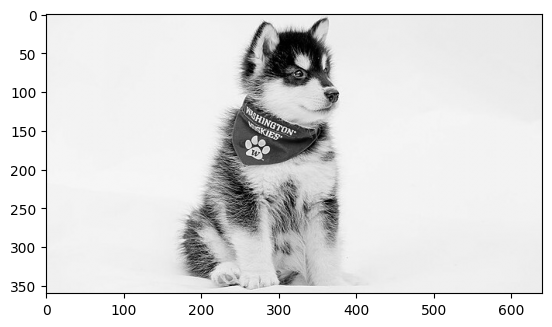

In [2]:
# Read image as grayscale
dubs = iio.imread("dubs.jpg", mode="L")
plt.imshow(dubs, cmap="gray");

If $f$ represents our input image, what is the role of $g$? Let's watch a clip from 3Blue1Brown (Grant Sanderson).

In [3]:
%%html
<iframe width="640" height="360" src="https://www.youtube-nocookie.com/embed/KuXjwB4LzSA?start=538&end=588" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

In this example, $g$ is a 3-by-3 [**box blur**](https://en.wikipedia.org/wiki/Box_blur) *kernel* that is applied to each patch or *subimage* in $f$.

$$g = \begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\[0.3em]
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\[0.3em]
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}
\end{bmatrix}$$

A convolution is like a special way of looping over the pixels in an image. Instead of looping over an image one pixel at a time, a **convolution** loops over an image one **subimage** (patch) at a time. Convolutions are also often called "sliding window algorithms" because they start at the top row, generate the first subimage for the top leftmost corner, then *slide over* 1 pixel to the right, and repeats until every subimage has been generated.

Here's how we can create this kernel in Python:

In [4]:
box_blur_3x3 = 1 / 9 * np.ones((3, 3))
box_blur_3x3

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

## Practice: Get subimages

Uncomment the line code in the body of the loop that will correctly slice the subimage matching the given kernel shape.

In [5]:
def get_subimages(image, kernel_shape):
    """Returns an array of subimages matching the given kernel shape."""
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel_shape
    subimages_h = image_h - kernel_h + 1
    subimages_w = image_w - kernel_w + 1
    subimages = np.zeros((subimages_h, subimages_w, kernel_h, kernel_w))
    for ih in range(subimages_h):
        for iw in range(subimages_w):
            # subimages[ih, iw] = image[iw:iw + kernel_w,     ih:ih + kernel_h]
            # subimages[ih, iw] = image[iw:iw + kernel_w + 1, ih:ih + kernel_h + 1]
            # subimages[ih, iw] = image[ih:ih + kernel_h,     iw:iw + kernel_w]
            # subimages[ih, iw] = image[ih:ih + kernel_h + 1, iw:iw + kernel_w + 1]
    return subimages

IndentationError: expected an indented block after 'for' statement on line 9 (3132513969.py, line 14)

In [ ]:
dubs_eye = dubs[50:100, 300:350]
plt.imshow(dubs_eye, cmap="gray");

In [ ]:
dubs_eye_subimages = get_subimages(dubs_eye, (3, 3))
compare(dubs_eye_subimages[(30, 20)], dubs_eye[30:33, 20:23])
assert np.allclose(dubs_eye_subimages[(30, 20)], dubs_eye[30:33,20:23])

## Practice: Sum of element-wise products

Write a NumPy expression to compute the sum of element-wise products between the current subimage and the given kernel.

In [ ]:
def convolve(image, kernel):
    """Returns the convolution of the image and kernel where the image shrinks by kernel shape."""
    subimages = get_subimages(image, kernel.shape)
    subimages_h, subimages_w = subimages.shape[:2]
    result = np.zeros((subimages_h, subimages_w))
    for ih in range(subimages_h):
        for iw in range(subimages_w):
            # TODO: compute the sum of element-wise product between subimage and kernel
            result[ih, iw] = ...
    return result


dubs_blurred = convolve(dubs, box_blur_3x3)
compare(dubs, dubs_blurred)

What will the result look like if we make the kernel larger? How about a 10-by-10 kernel instead of a 3-by-3 kernel?

In [ ]:
box_blur_10x10 = np.ones((10, 10))
box_blur_10x10 /= box_blur_10x10.size
box_blur_10x10

The entries in this kernel sum up to 1 to ensure that the resulting image is an average over the image. 10-by-10 is a somewhat awkward shape since we no longer have a notion of the exact center pixel, but the convolution code still works.

In [ ]:
dubs_blurred_10x10 = convolve(dubs, box_blur_10x10)
compare(dubs, dubs_blurred_10x10)

## Understanding kernels

What other kernels exist? Let's try to deduce what a kernel might do to an image.

This kernel has 0's all around except for a 1 in the center of the kernel.

In [ ]:
kernel = np.zeros((3, 3))
kernel[1, 1] = 1
kernel

In [ ]:
compare(dubs, convolve(dubs, kernel))

This kernel is computed by taking the double the previous mystery kernel and subtracting-out the box blur kernel.

In [ ]:
# Setup the previous kernel
kernel = np.zeros((3, 3))
kernel[1, 1] = 1
# Double the previous kernel minus the box blur kernel
kernel = 2 * kernel - box_blur_3x3
kernel

In [ ]:
compare(dubs, convolve(dubs, kernel))

This 10-by-10 kernel places a bell curve around the center with values shrinking the further you get from the center.

In [ ]:
values = [[1, 2, 4, 7, 11, 11, 7, 4, 2, 1]]
kernel = np.array(values) * np.array(values).T
kernel = kernel / kernel.sum()
# Show values rounded to two decimal places
kernel.round(2)

In [ ]:
compare(dubs, convolve(dubs, kernel))

## Practice: Template match

Write a function `template_match` that finds instances of a small template inside a larger image. Given an image and a template that can be found within it, `template_match` returns an array of values representing the pixel-by-pixel similarity between the template and each corresponding subimage.

This algorithm essentially applies a convolution over the image using the template as the kernel. However, using the raw pixel values will favor brighter pixels. Instead, we first have to de-mean both the template and the current subimage by subtracting the average pixel values.

In [ ]:
def template_match(image, template):
    """
    Given a grayscale image and template, returns a numpy array that stores the similarity of the
    template at each position in the image.
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    # De-mean the template
    demeaned_template = template - template.mean()

    # Construct result of the expected output size
    result = np.zeros((..., ...))
    result_h, result_w = result.shape

    for ih in range(result_h):
        for iw in range(result_w):
            # Select corresponding subimage
            subimage = ...

            # De-mean the subimage
            demeaned_subimage = subimage - subimage.mean()

            # Compute sum of element-wise products
            similarity = ...
            result[ih, iw] = similarity

    return result


match = template_match(dubs, dubs_eye)
compare(dubs, match)
np.unravel_index(match.argmax(), match.shape)